# Optimización - Laboratorio 11

### Isabella Salgado 201730418
### Juan Pablo Naranjo 201730006

## Librerías para el laboratorio

In [12]:
import numpy as np
from numpy import inf
from numpy import linalg as LA
import sympy as sym
from sympy import *
from scipy.optimize import linprog
from scipy.optimize import minimize
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import random
import numdifftools as nd
from scipy.io import loadmat
from IPython.display import HTML
import time

## Funciones para el laboratorio

### Funciones para lectura de datos

In [13]:
def int2byte(number):
    string ='{0:09b}'.format(number)
    salida =[]
    for elem in string:
        salida.append(int(elem))
    return salida

def convert_tuple2bytearray(pair_of_numbers=[]):
    array1 = int2byte(pair_of_numbers[0])
    array2 = int2byte(pair_of_numbers[1])
    array_return =[]
    array_return.extend(array1)
    array_return.extend(array2)
    return array_return
    
def convert_byteArray2tuple(byte_array):
    first_number = int("".join(list(map(str,byte_array[:9]))),2)
    second_number = int("".join(list(map(str,byte_array[9:]))),2)
    return (first_number,second_number)

### Algoritmo genético

In [22]:
def algoritmo_genetico(generaciones,
                       numero_de_individuos,
                       tasa_cross_over,
                       tasa_mutacion,
                       alturas):
  
    # Crea población inicial
    m,n =np.shape(alturas)
    poblacion_filas=np.random.randint(0, m, numero_de_individuos)
    poblacion_columnas = np.random.randint(0, n, numero_de_individuos)
    poblacion = list(zip(poblacion_filas,poblacion_columnas))
    poblacion =list(map(convert_tuple2bytearray,poblacion))

    # Vectores en cada eje
    x = range(n)
    y = range(m)

    # Se guards historia
    history = []    
    historyTup = []
    fig = plt.figure()
    ax = plt.subplot()
    # hl, = plt.plot([], [])

    mejores, mejores_pos, fitness_mejores = [], [], []

    print('Generaciones:')
    for gen in range(generaciones):
      
        # Imprime generación actual
        Tgen = gen + 1
        if (Tgen)%20 == 0 or Tgen == generaciones:
            print(Tgen)
        else:
            print(Tgen, end=' - ')

        # Crea siguiente generación
        poblacion =  crear_hijos(poblacion,
                                 m, n,
                                 tasa_cross_over,
                                 tasa_mutacion,
                                 alturas,
                                 numero_de_individuos)


        poblacionTup = {'X': [], 'Y': []}

        for elem in poblacion:
            X,Y = convert_byteArray2tuple(elem)
            poblacionTup['X'].append(X)
            poblacionTup['Y'].append(Y)
        
        # Guarda
        history.append(poblacionTup)

        # Dibuja contorno
        ax.contourf(x, y, alturas)

     
        # Evalua estado de la población.
        fitness_poblacion = list(map(lambda x:evaluar_candidato(x,colombia=alturas),
                                    poblacion))
        
        # Guarda mejor resultado
        mejor_gen = np.argmax(fitness_poblacion) 
        mejores.append(mejor_gen)
        mejores_pos.append(convert_byteArray2tuple(poblacion[mejor_gen]))

        fitness_mejores.append(np.max(fitness_poblacion))

    # Obtiene mejor resultado
    mejor = mejores_pos[fitness_mejores.index(np.max(fitness_mejores))]
    
    return mejor, history, mejores_pos, fitness_mejores

In [15]:
def hacer_factible(byte_array,maximo_filas,maximo_columnas):
    num1, num2 = convert_byteArray2tuple(byte_array)
    num1 = num1 if num1 < maximo_filas else maximo_filas-1
    num2 = num2 if num2 < maximo_columnas else maximo_columnas-1
    salida = convert_tuple2bytearray((num1,num2))
    return salida

In [16]:
def evaluar_candidato(byte_array,colombia):
    num1,num2 = convert_byteArray2tuple(byte_array)
    return colombia[num1,num2]  

In [17]:
def crear_hijos(población,maximo_filas,maximo_columnas,crosover_rate,mutation_rate,colombia,max_poblacion):

    max_hijos = 30

    fitness = list(map(lambda x:evaluar_candidato(x,colombia=colombia),población))
    sorted_indexes = np.argsort(fitness)
    best_parents = np.array(población)[sorted_indexes[-14:]]
    indice_crossover = int((9*2)*crosover_rate)
    temp_poblacion=[]
    for i in range(len(best_parents)):
        for j in range(i+1,len(best_parents)):
            parent1 = best_parents[i]
            parent2 = best_parents[j]


            hijo1 = []
            hijo2 = []
            hijo1.extend(parent1[indice_crossover:])
            hijo2.extend(parent1[:indice_crossover])
            hijo1.extend(parent2[:indice_crossover])
            hijo2.extend(parent2[indice_crossover:])
            if np.random.rand()< mutation_rate:
                indice =np.random.randint(0,len(hijo1))
                hijo1[indice] = int(hijo1[indice]^1)
            if np.random.rand()< mutation_rate:
                indice =np.random.randint(0,len(hijo2))
                hijo2[indice] = int(hijo2[indice]^1)
            hijo1 = hacer_factible(hijo1,maximo_filas,maximo_columnas)
            hijo2 = hacer_factible(hijo2,maximo_filas,maximo_columnas)
            temp_poblacion.append(hijo1)
            temp_poblacion.append(hijo2)
            if len(temp_poblacion) > max_hijos:
                break

    temp_poblacion.extend(población)
    whole_fitness = list(map(lambda x:evaluar_candidato(x,colombia=colombia),temp_poblacion))
    best_individuals = np.argsort(whole_fitness)

    return np.array(temp_poblacion)[best_individuals[-max_poblacion:]]

### Funciones para Gráficar

In [18]:
def visualizar_algoritmo_genetico(alturas,history):

    # Recalculamos variables importantes
    generaciones = len(history)
    m,n=np.shape(alturas)

    # Vectores en cada eje
    x = range(n)
    y = range(m)

    # Grilla
    X,Y = np.meshgrid(x,y)

    # Figura inicial
    fig = plt.figure()
    ax = plt.axes(xlim=(0, n), ylim=(0, m), xlabel='x', ylabel='y')
    ax.set_aspect(aspect='equal')

    # Mapa de colombia
    cvals = np.linspace(np.min(alturas),np.max(alturas),10)      
    cont = ax.contourf(X, Y, alturas, cvals)  

    # Población Inicial
    poblacion = history[0]
    scatter = ax.scatter(poblacion['X'], poblacion['Y'], color = 'darkred')

    # Función para animar
    def animate(i):
        # Actualiza población
        poblacion = history[i]
        scatter.set_offsets(np.asarray([poblacion['X'], poblacion['Y']]).T)

        # Actualiza titulo
        plt.title('Generación : %i' %(i + 1))

        return cont, scatter

    anim = FuncAnimation(fig, animate, frames=generaciones, repeat=False)

    return anim


## Solución

### Parámetros

In [19]:
datos = loadmat("colom.mat")
alturas = datos["colom"]

# Parámetros algoritmo genético
generaciones = 50
numero_de_individuos = 50
tasa_cross_over = 0.7
tasa_mutacion = 0.3

### Correr Algoritmo

Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50


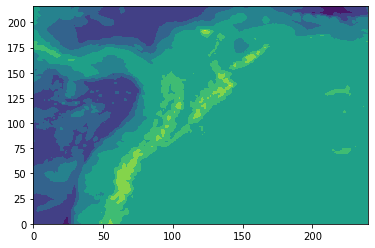

In [20]:
mejor, history, mejores, fitness_mejores = algoritmo_genetico(generaciones,
                                                              numero_de_individuos,
                                                              tasa_cross_over,
                                                              tasa_mutacion,
                                                              alturas)

## Visualizar

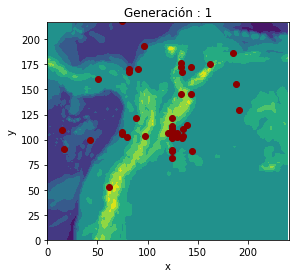

In [21]:
anim = visualizar_algoritmo_genetico(alturas, history)
HTML(anim.to_jshtml())

## Punto 1

In [27]:
numGen = [30, 100, 200]
tamPopu = [30, 100, 150]
xover_rate = [0.1, 0.3, 0.5, 0.7, 0.9]
mutate_rate = [0.01, 0.05, 0.1, 0.3]

mej = [] 
hist = []
mejs = [] 
fit = []

Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 -

<ipython-input-22-048c45951c92>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25

41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 

81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 

21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 

61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 

121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 10

21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 106 - 107 - 108 - 109 - 110 - 111 - 112 - 113 - 114 - 115 - 116 - 117 - 118 - 119 - 120
121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 -

121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 10

21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 106 - 107 - 108 - 109 - 110 - 111 - 112 - 113 - 114 - 115 - 116 - 117 - 118 - 119 - 120
121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 -

121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 10

21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 106 - 107 - 108 - 109 - 110 - 111 - 112 - 113 - 114 - 115 - 116 - 117 - 118 - 119 - 120
121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 -

121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20
21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 10

21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40
41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60
61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80
81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100
101 - 102 - 103 - 104 - 105 - 106 - 107 - 108 - 109 - 110 - 111 - 112 - 113 - 114 - 115 - 116 - 117 - 118 - 119 - 120
121 - 122 - 123 - 124 - 125 - 126 - 127 - 128 - 129 - 130 - 131 - 132 - 133 - 134 - 135 - 136 - 137 - 138 - 139 - 140
141 - 142 - 143 - 144 - 145 - 146 - 147 - 148 - 149 - 150 - 151 - 152 - 153 - 154 - 155 - 156 - 157 - 158 - 159 - 160
161 - 162 - 163 - 164 - 165 - 166 - 167 - 168 - 169 - 170 - 171 - 172 - 173 - 174 - 175 - 176 - 177 - 178 - 179 - 180
181 - 182 - 183 - 184 - 185 - 186 - 187 - 188 - 189 - 190 - 191 - 192 - 193 - 194 - 195 - 196 - 197 - 198 - 199 - 200
Generaciones:
1 -

KeyboardInterrupt: 

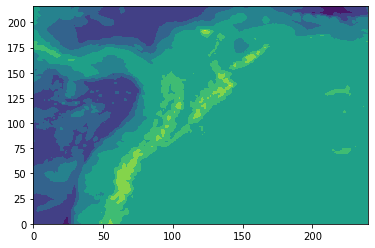

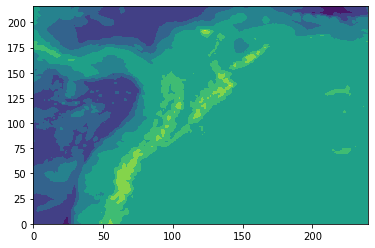

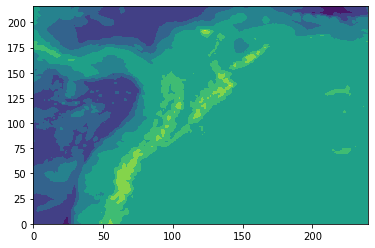

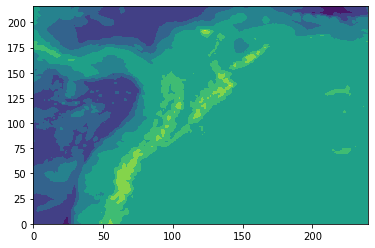

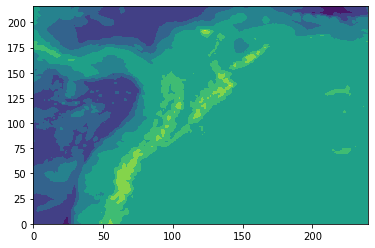

In [ ]:
c = 0
for gen in numGen:
    for pop in tamPopu:
        for x in xover_rate:
            for mut in mutate_rate:
                mejor, history, mejores, fitness_mejores = algoritmo_genetico(gen, pop, x, mut, alturas)
                mej.append(mejor)